# Builds the Seg Map and Catalog; Then, matches catalogs to get SEDs

In [10]:
# General imports
import os
import numpy as np
import matplotlib.pyplot as plt

# Segmentation
from astropy.io import fits
from photutils.segmentation import SourceFinder, make_2dgaussian_kernel, SourceCatalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve

# Catalog Writing
from astropy.table import Table, Column

os.chdir("/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits")
root = "GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits" # Change filename with this variable
direct_file = root
seg_file = "seg_{0}".format(root)
cat_file = "cat_{0}.detect.cat".format(root)

In [11]:
# Process direct image and produce segmentation map

# Open image
direct_fits = fits.open(direct_file)
data, header = (direct_fits[1].data, direct_fits[1].header)
direct_fits.close()

# Subtract background
bkg_estimator = MedianBackground()
bkg = Background2D(data, (511,511), filter_size=(7,7), bkg_estimator=bkg_estimator)
data -= bkg.background

# Convolve image
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(data, kernel)

# Instantiate the SourceFinder and set threshold
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.01)
threshold = 1.5 * bkg.background_rms

seg_map = finder(convolved_data, threshold)

# Save seg_map as fits
# fits.writeto(seg_file, np.rot90(seg_map, k=3), header=header,overwrite=True)

Deblending:   0%|          | 0/6976 [00:00<?, ?it/s]

In [12]:
# Create Catalog
cat = SourceCatalog(data, seg_map, convolved_data=convolved_data)

# Grizli Expects these later
cat.add_extra_property('id', np.cast[int](cat.label), overwrite=True)
cat.add_extra_property('x_flt', cat.xcentroid, overwrite=True)
cat.add_extra_property('y_flt', cat.ycentroid, overwrite=True)

# Calculate flux using a reference object (reference object info hardcoded)
mag = -2.5 * np.log10(cat.segment_flux/206.04939338564867) + 25.88
cat.add_extra_property('mag_approx', mag, overwrite=True)

# Convert cumbersome catalog into usable table
columns = ['id', 'x_flt', 'y_flt', 'mag_approx', 'segment_flux']
tbl = cat.to_table(columns)

In [13]:
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')

NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,MAG_F1500W,SPECTEMP,Z,MODIMAGE,MODIMAGE_1,MODIMAGE_2
int64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64
4,2965.4511,4056.978,0.6203,0.388,21.95,26.21,4,1.374447,0,9.4302282,-0.6739474
46,340.3526,908.0579,1.8571,0.4785,243.59,21.64,46,0.958482,0,9.5106588,-0.7718471
47,313.286,837.3047,1.814,0.8653,125.64,23.96,47,0.958811,0,9.5114989,-0.7740602
48,453.5686,848.8077,4.4273,4.1741,98.6,22.18,48,0.958589,0,9.5072026,-0.7736788
52,3854.294,3623.7213,1.5177,0.9869,110.22,23.03,52,2.654787,0,9.4031738,-0.6872854
53,3904.9373,3694.7973,2.0546,1.1478,264.9,24.07,53,2.654781,0,9.4016304,-0.6850911
54,3719.5634,3484.9821,2.2213,2.1337,32.39,22.65,54,2.654636,0,9.40728,-0.6915712
55,3822.519,3453.6168,1.67,1.5368,323.4,24.01,55,2.655306,0,9.4041444,-0.6925379
56,3854.3317,3388.7815,1.5708,1.1978,246.17,26.67,56,2.655155,0,9.4031764,-0.69454


In [14]:
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')
                    
column = Column(name="mag", length=len(tbl), dtype=float)
tbl.add_column(column)

column = Column(name="hlss_id", length=len(tbl))
tbl.add_column(column)             

column = Column(name="distance", length=len(tbl))
tbl.add_column(column)       

column = Column(name="z", length=len(tbl))
tbl.add_column(column)   

column = Column(name="MODIMAGE", length=len(tbl), dtype=int)
tbl.add_column(column) 

column = Column(data=np.empty(len(tbl)), name="SED", dtype=str)
tbl.add_column(column)


# Adding this for patches
column = Column(name="A_IMAGE", length=len(tbl), dtype=float)
tbl.add_column(column) 

column = Column(name="B_IMAGE", length=len(tbl), dtype=float)
tbl.add_column(column) 

column = Column(name="THETA_IMAGE", length=len(tbl), dtype=float)
tbl.add_column(column) 


del column

In [15]:
# Find potential matches
for ii, object in enumerate(tbl):
    tbl_x, tbl_y = object["x_flt"], object["y_flt"]
    hlss_x, hlss_y = hlss_tbl["X_IMAGE"], hlss_tbl["Y_IMAGE"]

    d2d_squared = (tbl_x - hlss_x)**2 + (tbl_y - hlss_y)**2

    min_d2d = np.min(d2d_squared)

    min_match_dist = 10**2

    if min_d2d < min_match_dist:
        min_index = np.argmin(d2d_squared)

        # Store match
        tbl["hlss_id"][ii] = hlss_tbl["NUMBER"][min_index]
        tbl["distance"][ii] = min_d2d

        # Store match's info from the HLSS catalog
        tbl["SED"][ii] = "SED:rest:gal.{0}.fits".format(hlss_tbl['SPECTEMP'][min_index])
        tbl["MODIMAGE"][ii] = hlss_tbl["MODIMAGE"][min_index]
        tbl['z'][ii] = hlss_tbl['Z'][min_index]
        tbl["mag"][ii] = hlss_tbl["MAG_F1500W"][min_index]


        # Adding this for patches
        tbl["A_IMAGE"][ii] = hlss_tbl["A_IMAGE"][min_index]
        tbl["B_IMAGE"][ii] = hlss_tbl["B_IMAGE"][min_index]
        tbl["THETA_IMAGE"][ii] = hlss_tbl["THETA_IMAGE"][min_index]


matches = len(np.where(tbl["hlss_id"] != 0)[0])
print("# of matches: ", matches)

# of matches:  8195


In [16]:
from collections import defaultdict

D = defaultdict(list)

for row_num, hlss_id in enumerate(tbl['hlss_id']):
    # if hlss_id == 0:
    #     continue
    D[hlss_id].append(row_num)
D = {k:v for k,v in D.items() if len(v)>1}

print("# of double matched objects: ", len(D))
print("# of matches without doubles: ", len(tbl) - len(D))

# Identify farthest duplicates; assume those should be removed
remove = []
for key in D.keys():
    row_nums = D[key]
    keep = row_nums[np.argmin([tbl[ii]["distance"] for ii in row_nums])]
    remove.append([ii for ii in row_nums if ii != keep])

# Remove Duplicates
for row_num in remove:
    tbl["hlss_id"][row_num] = str(0.0)
    tbl["distance"][row_num] = str(0.0)
    tbl["SED"][row_num] = str(0.0)

tbl = tbl[np.where(tbl["hlss_id"] != 0.0)]

# Save Catalog
if os.path.exists(cat_file):
            os.remove(cat_file)
tbl.write(cat_file, format="ascii.ecsv")

# of double matched objects:  18
# of matches without doubles:  8368


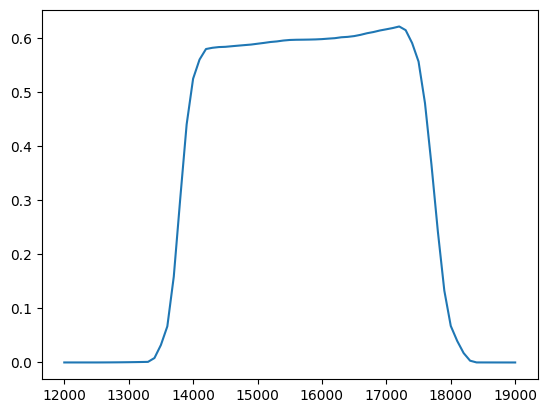

In [24]:
import pysynphot as S

bp = S.ArrayBandpass(df["WAVELENGTH"], df["THROUGHPUT"])

plt.plot(bp.wave, bp.throughput)